# 이제까지 만들었던 모델을 튜닝하고 배포하기

# 1. 하이퍼파라미터 튜닝
-  튜닝한 하이퍼 파라미터로 학습을 진행하고 모델을 SavedModel 형식으로 저장한다

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.1/127.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split

- MNIST dataset을 불러온다

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# 데이터 전처리
X_train = x_train.reshape(-1, 28, 28, 1)  # reshaping for convnet
X_test = x_test.reshape(-1, 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape)

(48000, 28, 28, 1)


- CNN모델을 사용할 것이기 때문에 CNN 모델을 정의해준다.

In [ ]:
# CNN 모델 정의
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
                                  kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
                                  activation='relu',
                                  input_shape=(28, 28, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=64), activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

- Hyperband 튜너를 설정해준다

In [ ]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hyperband',
                     project_name='mnist')

- 파라미터 서치

In [ ]:
tuner.search(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

Trial 30 Complete [00h 15m 24s]
val_accuracy: 0.9850000143051147

Best val_accuracy So Far: 0.9861999750137329
Total elapsed time: 02h 48m 12s


- 최적의 하이퍼파라미터 및 모델 선택

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

- 모델 훈련

In [ ]:
best_model.fit(X_train, y_train, batch_size=128, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
375/375 [==============================] - 128s 340ms/step - loss: 2.6391 - accuracy: 0.8821 - val_loss: 0.0909 - val_accuracy: 0.9747
Epoch 2/5
375/375 [==============================] - 129s 344ms/step - loss: 0.1329 - accuracy: 0.9615 - val_loss: 0.0578 - val_accuracy: 0.9831
Epoch 3/5
375/375 [==============================] - 124s 331ms/step - loss: 0.1031 - accuracy: 0.9706 - val_loss: 0.0508 - val_accuracy: 0.9843
Epoch 4/5
375/375 [==============================] - 124s 331ms/step - loss: 0.0825 - accuracy: 0.9756 - val_loss: 0.0598 - val_accuracy: 0.9819
Epoch 5/5
375/375 [==============================] - 124s 330ms/step - loss: 0.0741 - accuracy: 0.9779 - val_loss: 0.0550 - val_accuracy: 0.9840


In [ ]:
best_model.evaluate(X_test, y_test)

313/313 [==============================] - 6s 21ms/step - loss: 0.0550 - accuracy: 0.9840


[0.05499516427516937, 0.984000027179718]

In [ ]:
test_index = np.random.randint(0, X_test.shape[0])
test_image = X_test[test_index]
true_label = np.argmax(y_test[test_index])

prediction = best_model.predict(np.expand_dims(test_image, axis=0))
predicted_label = np.argmax(prediction)

1/1 [==============================] - 0s 187ms/step


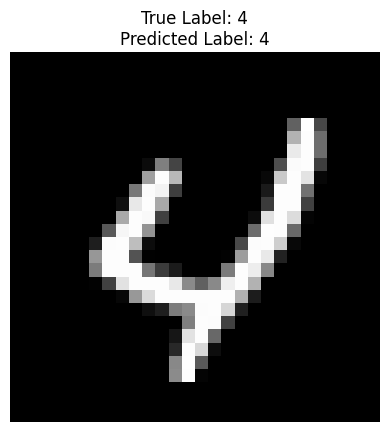

In [ ]:
plt.imshow(test_image.reshape(28, 28), cmap='gray')
plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
plt.axis('off')
plt.show()

- 모델 저장
  - saved_model.pb : pb는 프로토콜 버퍼를 의미하며 해당 파일은 내보낸 모델 그래프 구조를 포함
  - variables : 내보낸 변수값이 있는 이진 파일과 내보낸 모델 그래프에 해당하는 체크포인트를 포함
  - assets : 내보낸 모델을 불러올 때 추가적인 파일이 필요한 경우 이 폴더에 파일이 생성

- 케라스의 경우 .keras 파일을 선호. 가중치와 모델을 전부 하나의 파일로 관리한다.

In [ ]:
import os
save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model')
best_model.save(fname)

# 2. 모델 배포하기
- 하이퍼파라미터 튜닝을 끝낸 모델을 Docker 혹은 WSL2 환경에서 TFServing을 진행해 모델을 배포.

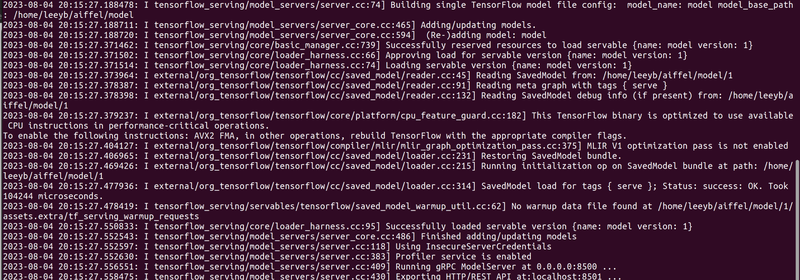

# 3. TFLite 모델 만들기

In [ ]:
# TFLite 모델로 변환
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

In [ ]:
# TFLite 모델 저장
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
# TFLite 모델 로드 및 서명 확인
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_model)
tflite_interpreter.allocate_tensors()

In [ ]:
# 모델 정보 출력
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()
print("Input details:", input_details)
print("Output details:", output_details)

Input details: [{'name': 'serving_default_conv2d_1_input:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 13, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
